In this notebook, we will implement, train, and apply an **Artificial Neural Network (ANN)** using a Python library `PyTorch``.

We will use the implemented neural network to classify images of **handwritten digits** (i.e., data without defined categories or groups).

# 0. LIBRARIES IMPORT

In [1]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


Create a structure of notebook sub-directories to store the data as well as the trained neural network models:

In [6]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

In [3]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

Enable GPU computing:

In [4]:
# set gpu enabled flag
use_gpu = True

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

In [5]:
#check
!nvidia-smi

Sun Apr 14 19:29:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1. DATA PROCESSING

## a. data acquisition

The **MNIST database** (**M**odified **N**ational **I**nstitute of **S**tandards and **T**echnology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is widely used for training and testing in the field of machine learning.

The MNIST database contains **60,000 training images** and **10,000 evaluation images**. The handwritten digits contained in each fixe-sized image have been size-normalized and centred. The MNIST dataset is a great dataset to start with when learning about machine learning techniques and pattern recognition methods on real-world data. It requires minimal efforts on preprocessing and formatting the distinct images.

Let's download the training data

In [ ]:
train_path = './data/train_mnist'

# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
mnist_train_data = torchvision.datasets.MNIST(root=train_path, train=True, transform=transf, download=True)

In [8]:
# determine the number of training data images
len(mnist_train_data)

60000

let's inspect some samples:

In [ ]:
# select and set a (random) image id
image_id = 7779

# retrieve image exhibiting the image id
mnist_train_data[image_id]

Ok, that doesn't seem right :). Let's now seperate the image from its label information:

In [10]:
mnist_train_image, mnist_train_label = mnist_train_data[image_id]

Great, let's now visually inspect our sample image:

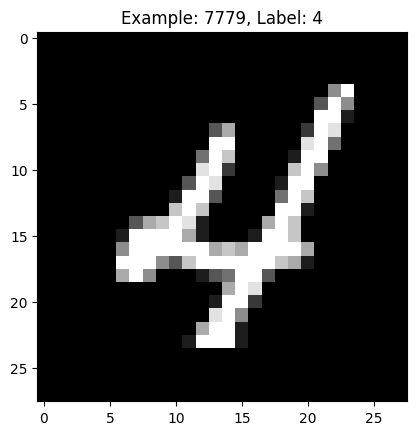

In [11]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), str(mnist_train_label)))

# plot mnist handwritten digit sample
plt.imshow(trans(mnist_train_image), cmap='gray')

let's do the same thing for evaluation data:

In [ ]:
eval_path = './data/eval_mnist'

# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
mnist_eval_data = torchvision.datasets.MNIST(root=eval_path, train=False, transform=transf, download=True)

In [13]:
# determine the number of evaluation data images
len(mnist_eval_data)

10000

# 2. NEURAL NETWORK IMPLEMENTATION

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable to classify the 28x28 pixel MNIST images of handwritten digits.

## a. architecture

The neural network, which we name **'MNISTNet'** consists of three **fully-connected layers** (including an “input layer” and two hidden layers). Furthermore, the **MNISTNet** should encompass the following number of neurons per layer: 100 (layer 1), 50 (layer 2) and 10 (layer 3). Meaning the first layer consists of 100 neurons, the second layer of 50 neurons and third layer of 10 neurons (the number of digit classes we aim to classify.

In [14]:
# implement the MNISTNet network architecture
class MNISTNet(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(MNISTNet, self).__init__()

        # specify fully-connected (fc) layer 1 - in 28*28, out 100
        self.linear1 = nn.Linear(28*28, 100, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity

        # specify fc layer 2 - in 100, out 50
        self.linear2 = nn.Linear(100, 50, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear3 = nn.Linear(50, 10) # the linearity W*x+b

        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

    # define network forward pass
    def forward(self, images):

        # reshape image pixels
        x = images.view(-1, 28*28)

        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))

        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))

        # return forward pass result
        return x

The **softmax function**, also known as the normalized exponential function, is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities.

That is, prior to applying softmax, some vector components could be negative, or greater than one; and might not sum to 1; but after application of the softmax, each component will be in the interval $(0,1)$, and the components will add up to 1, so that they can be interpreted as probabilities. In general, the softmax function $\sigma :\mathbb {R} ^{K}\to \mathbb {R} ^{K}$ is defined by the formula:

<center> $\sigma (\mathbf {z} )_{i}=\ln ({e^{z_{i}} / \sum _{j=1}^{K}e^{z_{j}}})$ </center>

for $i = 1, …, K$ and ${\mathbf {z}}=(z_{1},\ldots ,z_{K})\in \mathbb {R} ^{K}$ (Source: https://en.wikipedia.org/wiki/Softmax_function ).

In [15]:
model = MNISTNet()

Once the model is initialized, we can visualize the model structure and review the implemented network architecture:

In [16]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



Finally, let's have a look into the number of model parameters that we aim to train in the next steps:

In [19]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()

# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 84060.


In [20]:
# case: gpu computing enabled
if use_gpu == True:

  # push model to the GPU
  model = model.cuda()

## b. loss function

Prior to starting the training, we need to define an appropriate loss function. Here, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given handwritten digit image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible.

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\arg\min_{\theta} \|C - f_\theta(X)\|$ over all training images in the MNIST dataset. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this lab we use the **'Negative Log Likelihood (NLL)'** loss, defined by:

<center> $\mathcal{L}^{NLL}_{\theta} (c_i, \hat c_i) = - \frac{1}{N} \sum_{i=1}^N \log (\hat{c}_i) $, </center>

for a set of $n$-MNIST images $x^{i}$, $i=1,...,n$ and their respective predicted class labels $\hat{c}^{i}$. This is summed for all the correct classes.


During training the **NLL** loss will penalize models that result in a high classification error between the predicted class labels $\hat{c}^{i}$ and their respective true class label $c^{i}$.

In [21]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

In [22]:
# case: gpu computing enabled
if use_gpu == True:

  # push the loss calculation to the GPU
  nll_loss = nll_loss.cuda()

## c. training

So far, we have pre-processed the dataset, implemented the ANN and defined the classification error. Let's now start to train a corresponding model for **20 epochs** and a **mini-batch size of 128** MNIST images per batch. This implies that the whole dataset will be fed to the ANN 20 times in chunks of 128 images yielding to **469 mini-batches** (60.000 images / 128 images per mini-batch) per epoch.

In [23]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

We will use the **Stochastic Gradient Descent (SGD) optimization** and set the learning-rate $l = 0.001$. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the MSE loss).

In [24]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

Furthermore, lets specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [25]:
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, batch_size=mini_batch_size, shuffle=True)

Finally, we start training the model. The detailed training procedure for each mini-batch is performed as follows:

>1. do a forward pass through the MNISTNet network,
>2. compute the negative log likelihood classification error $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$,
>3. do a backward pass through the MNISTNet network, and
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training our ANN model, we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the classification performance of the entire training dataset after each training epoch. Based on this evaluation, we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:

>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [26]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(mnist_train_dataloader):

        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()

        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        # determine classification loss
        loss = nll_loss(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # save model to local directory
    model_name = 'mnist_model_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20240414-20:02:12] epoch: 0 train-loss: 2.3002859676824703
[LOG 20240414-20:02:18] epoch: 1 train-loss: 2.2875820238198807
[LOG 20240414-20:02:25] epoch: 2 train-loss: 2.273266054165643
[LOG 20240414-20:02:32] epoch: 3 train-loss: 2.255962809519981
[LOG 20240414-20:02:38] epoch: 4 train-loss: 2.233992708771468
[LOG 20240414-20:02:46] epoch: 5 train-loss: 2.2050284302310903
[LOG 20240414-20:02:52] epoch: 6 train-loss: 2.166054117145823
[LOG 20240414-20:02:59] epoch: 7 train-loss: 2.113092363516151
[LOG 20240414-20:03:06] epoch: 8 train-loss: 2.0432703972879502
[LOG 20240414-20:03:12] epoch: 9 train-loss: 1.9543514221207674
[LOG 20240414-20:03:19] epoch: 10 train-loss: 1.84480736377651
[LOG 20240414-20:03:25] epoch: 11 train-loss: 1.7174425023451034
[LOG 20240414-20:03:32] epoch: 12 train-loss: 1.5789194696747673
[LOG 20240414-20:03:39] epoch: 13 train-loss: 1.4382509643843433
[LOG 20240414-20:03:45] epoch: 14 train-loss: 1.3051628644532487
[LOG 20240414-20:03:52] epoch: 15 train-lo

let's visualize and inspect the training loss per epoch:

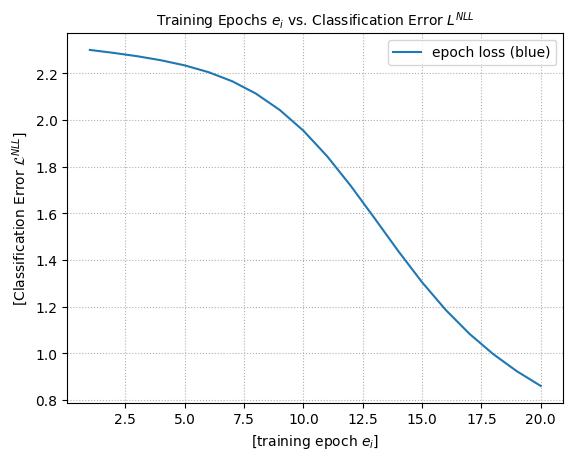

In [27]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

## d. evaluation

Before evaluating our model let's load the best performing model.

In [30]:
# restore pre-trained model snapshot
best_model_name = 'https://raw.githubusercontent.com/financial-data-science/CFDS-Notebooks/master/lab_11/models/mnist_model_epoch_100.pth'

# read stored model from the remote location
model_bytes = urllib.request.urlopen(best_model_name)

# load model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# init pre-trained model class
best_model = MNISTNet()

# load pre-trained models
best_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

Let's inspect if the model was loaded successfully:

In [31]:
# set model in evaluation mode
best_model.eval()

MNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

To evaluate our trained model, we need to feed the MNIST images reserved for evaluation:

In [32]:
mnist_eval_dataloader = torch.utils.data.DataLoader(mnist_eval_data, batch_size=10000, shuffle=True)

We will now evaluate the trained model using the same mini-batch approach as we did throughout the network training and derive the mean negative log-likelihood loss of the mini-batches:

In [33]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(mnist_eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20240414-20:08:06] eval-loss: 0.29266196489334106


Let's evaluate some samples:

In [34]:
# set (random) image id
image_id = 777

# retrieve image exhibiting the image id
mnist_eval_image, mnist_eval_label = mnist_eval_data[image_id]

Let's now inspect the true class of the image we selected:

In [35]:
mnist_eval_label

1

Ok, the randomly selected image should contain a one (1). Let's inspect the image accordingly:

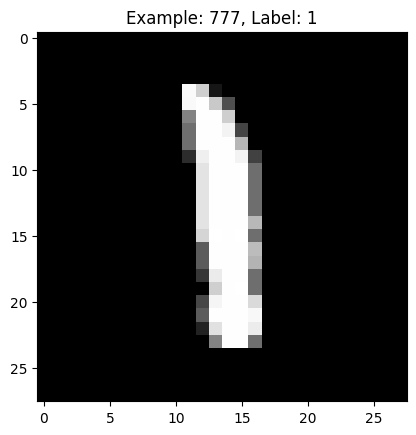

In [36]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), str(mnist_eval_label)))

# plot mnist handwritten digit sample
plt.imshow(trans(mnist_eval_image), cmap='gray')

Ok, let's compare the true label with the prediction of our model:

In [37]:
best_model(mnist_eval_image)

tensor([[-1.7474e+01, -1.0505e-02, -7.3498e+00, -5.8172e+00, -1.2160e+01,
         -7.3901e+00, -9.0477e+00, -8.5186e+00, -5.1436e+00, -9.8149e+00]],
       grad_fn=<LogSoftmaxBackward0>)

We can even determine the likelihood of the most probable class:

In [38]:
torch.argmax(best_model(mnist_eval_image), dim=1).item()

1

Let's now obtain the predictions for all the handwritten digit images of the evaluation data:

In [39]:
predictions = torch.argmax(best_model(mnist_eval_data.data.float()), dim=1)

Furthermore, let's obtain the overall classifcation accuracy:

In [40]:
metrics.accuracy_score(mnist_eval_data.targets, predictions.detach().numpy())

0.9092

Let's also inspect the confusion matrix to determine major sources of misclassification

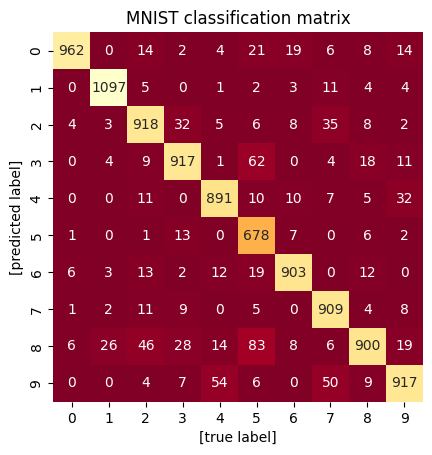

In [41]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(mnist_eval_data.targets, predictions.detach().numpy())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses the digits 3 and 5 as well the digits 9 and 4 quite often. This is not surprising since those digits exhibit a high similarity.